## Import packages

In [312]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [313]:
from torch.utils.data import random_split

In [314]:
import numpy as np

## Get device type

In [315]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.12.1.post201
DEVICE: cuda


## Define transforms

In [316]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    # rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()

    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        # rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

## Read dataset

In [317]:
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [340]:
# The size of the images
output_shape = [299, 299]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

train_ds_1 = CustomDataset(
    list_images=glob.glob("scenario_with_nst_undersample/scenario_2_undersample_10kbenign/train/*/*.jpg"),
    # transform=custom_transform
)

train_ds_2 = CustomDataset(
    list_images=glob.glob("scenario_with_nst_undersample/scenario_2_undersample_10kbenign/train/*/*.jpg"),
    transform=custom_transform
)


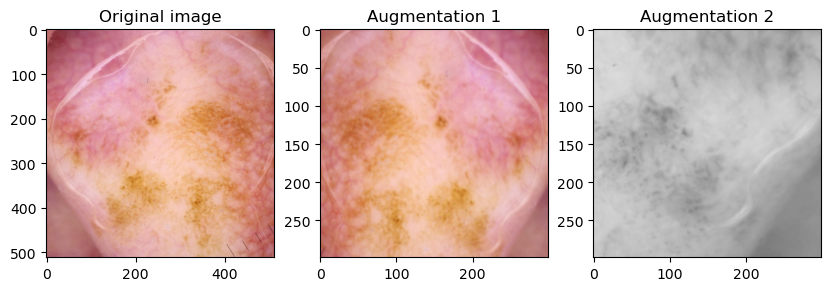

In [364]:
fig = plt.figure(figsize=(10,20))
rows = 1
columns = 3

def view_data(original_ds, transform_ds, index):
    original_image = original_ds[index]
    
    fig.add_subplot(rows, columns, 1)
    # plt.subplot(5,2,2*i-1)
    plt.imshow(original_image)
    plt.title("Original image")
    
    images = transform_ds[index]
    view1, view2 = images
    # plt.subplot(5,2,2*i)
    
    fig.add_subplot(rows, columns, 2)
    # plt.subplot(5,2,2*i-1)
    plt.imshow(view1.permute(1,2,0))
    plt.title("Augmentation 1")
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(view2.permute(1,2,0))
    plt.title("Augmentation 2")

view_data(train_ds_1, train_ds_2, 1400)

## Data loader

In [11]:
BATCH_SIZE = 64

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

## SimCLR model with pretrained InceptionV3 model for encoding

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        inceptionv3 = models.inception_v3(pretrained=True)
        # set_parameter_requires_grad(inceptionv3, True)
        inceptionv3.aux_logits = False
        inceptionv3.fc = Identity()
        inceptionv3.AuxLogits.fc = Identity()
        self.encoder = inceptionv3
        self.projection = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(), 
            nn.Linear(512, 256)
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)

        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [15]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [16]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

/home/ubuntu/miniconda3/envs/cs230_project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/cs230_project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
EPOCHS = 15
train_loss_list = []
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            train_loss_list.append(running_loss)
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

In [236]:
import torch
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

21988

In [ ]:
torch.save(simclr_model.state_dict(), "simclr_weights_scenario_2_with_nst.pt")

## Load model from saved weights

In [150]:
simclr_model = SimCLR()
simclr_model.load_state_dict(torch.load("simclr_weights_scenario_2_with_nst.pt"))

/home/ubuntu/miniconda3/envs/cs230_project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/cs230_project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

## Downstream task

In [151]:
from torchvision.transforms import (
    CenterCrop,
    Resize, 
    ToTensor
)

In [152]:
resize = Resize(400)
ccrop = CenterCrop(299)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

## Dataloaders for train, valid and test images

In [153]:
BATCH_SIZE = 64

In [154]:
train_ds_downstream = ImageFolder(
    root="scenario_with_nst_undersample/scenario_2_undersample_5kbenign/train",
    transform=custom_transform
)

nu_classes = len(train_ds_downstream.classes)

# Building the data loader
train_dl_downstream = torch.utils.data.DataLoader(
    train_ds_downstream,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

## Validation data dataloader

In [155]:
valid_ds_downstream = ImageFolder(
    root="valid",
    transform=custom_transform
)

# Building the data loader
valid_dl_downstream = torch.utils.data.DataLoader(
    valid_ds_downstream,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=False,
    pin_memory=True
)

In [244]:
test_ds_downstream = ImageFolder(
    root="test",
    transform=custom_transform
)

# Building the data loader
test_dl_downstream = torch.utils.data.DataLoader(
    test_ds_downstream,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=False,
    # pin_memory=True
)

In [239]:
len(test_dl_downstream.dataset)

298

## Downstream classification model

In [262]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear1 = nn.Linear(2048, nu_classes)
        # self.linear2 = nn.Linear(512, 256)
        # self.linear3 = nn.Linear(256, 128)
        # self.linear4 = nn.Linear(128, 64)
        # self.linear5 = nn.Linear(512, nu_classes)

    def forward(self, x):
        encoding = self.simclr(x)
        
        encoding = self.linear1(encoding)
        encoding = nn.BatchNorm1d(2, device=DEVICE)(encoding)
        encoding = nn.ReLU()(encoding)
        
        # encoding = self.linear2(encoding)
        # encoding = nn.BatchNorm1d(256, device=DEVICE)(encoding)
        # encoding = nn.ReLU()(encoding) 
        # # encoding = nn.Dropout(0.5)(encoding)

#         encoding = self.linear3(encoding)
#         encoding = nn.BatchNorm1d(128, device=DEVICE)(encoding)
#         encoding = nn.ReLU()(encoding)
        
#         encoding = self.linear4(encoding)
#         encoding = nn.BatchNorm1d(64, device=DEVICE)(encoding)
#         encoding = nn.ReLU()(encoding)
        
        # encoding = nn.Dropout(0.8)(encoding)
        
        pred = torch.sigmoid(encoding)
        return pred

In [263]:
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters(), lr=0.001)

## Calculate validation dataset loss

In [264]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data in valid_loader:
            image = data[0].to(device)
            label = data[1].to(device)

            pred = model(image)
            loss = loss_function(pred, label)

            loss_total += loss.item()

    return loss_total / len(valid_loader)

## Training the model with Early stopping

In [265]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [266]:
def traindata(device, model, epochs, optimizer, loss_function, train_loader, valid_loader):

    # Early stopping
    last_loss = 100
    min_loss = 100
    
    trained_model = model
    patience = 5
    triggertimes = 0

    train_loss_list = []
    valid_loss_list = []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for times, data in enumerate(train_loader):
            image = data[0].to(device)
            label = data[1].to(device)

            # Forward and backward propagation
            pred = model(image)
            loss = loss_function(pred, label)

            # Zero the gradients
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()

            # Loss for the epoch
            running_loss += loss.item()

            # Show progress after 100 mini-batches within an epoch
            # if times % 100 == 0 or times == len(train_loader):
            #     print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, times, len(train_loader), loss.item()))
        
        print(f"Loss after epoch {epoch}: {running_loss/len(train_loader)}")
        train_loss_list.append(running_loss/len(train_loader))

        # Early stopping
        current_loss = validation(model, device, valid_loader, loss_function)
        valid_loss_list.append(current_loss)

        print('Validation Loss: ', current_loss)

        if current_loss > last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping triggered!')
                return trained_model, train_loss_list, valid_loss_list
        else:
            trigger_times = 0

        if min_loss > current_loss:
            min_loss = current_loss
            trained_model = model

        last_loss = current_loss

    return model, train_loss_list, valid_loss_list

In [267]:
trained_model, train_loss_list, valid_loss_list = traindata(DEVICE, 
                                                eval_model,
                                                epochs=30,
                                                optimizer=optimizer,
                                                loss_function=criterion,
                                                train_loader=train_dl_downstream,
                                                valid_loader=valid_dl_downstream)

Loss after epoch 1: 0.6469792732778861
Validation Loss:  0.6780721187591553
Loss after epoch 2: 0.6416069615860375
Validation Loss:  0.6766583800315857
Loss after epoch 3: 0.6409297387818901
Validation Loss:  0.676532506942749
Loss after epoch 4: 0.6399000925677163
Validation Loss:  0.6742997527122497
Loss after epoch 5: 0.6397535052834725
Validation Loss:  0.6799662351608277
Loss after epoch 6: 0.6400142978040539
Validation Loss:  0.677300238609314
Loss after epoch 7: 0.6394160417269688
Validation Loss:  0.6759834289550781
Loss after epoch 8: 0.6395482049912823
Validation Loss:  0.6816093444824218
Loss after epoch 9: 0.6388053112492269
Validation Loss:  0.6795930862426758
Loss after epoch 10: 0.638454550078937
Validation Loss:  0.6792080640792847
Loss after epoch 11: 0.6386572688209767
Validation Loss:  0.6785850524902344
Loss after epoch 12: 0.6383434917245593
Validation Loss:  0.6792835116386413
Loss after epoch 13: 0.638436637970866
Validation Loss:  0.678683602809906
Loss after ep

## Test data performance

In [268]:
def get_accuracy_metrics(y_true_list, y_pred_list):
    print(len(y_pred_list))
    correct_count = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i, v in enumerate(y_pred_list):
        if v == y_true_list[i]:
            correct_count+=1
        if v == 1 and y_true_list[i] == 1:
            tp+=1
        if v == 0 and y_true_list[i] == 0:
            tn+=1
        if v == 1 and y_true_list[i] == 0:
            fp+=1
        if v == 0 and y_true_list[i] == 1:
            fn+=1

    accuracy_dict = {}
    accuracy_dict["true_positives"] = tp
    accuracy_dict["false_positives"] = fp
    accuracy_dict["true_negatives"] = tn
    accuracy_dict["false_negatives"] = fn
    
    print(accuracy_dict)
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    accuracy_dict["accuracy"] = accuracy
    recall = tp/(tp+fn)
    accuracy_dict["recall"] = recall
    precision = tp/(tp+fp)
    accuracy_dict["precision"] = precision    
    f1_score = 2*precision*recall/(precision+recall)
    accuracy_dict["f1_score"] = f1_score
    
    return accuracy_dict
    
    

## In sample prediction

In [269]:
y_pred_list = []
y_true_list = []

eval_model.eval()
for i, element in enumerate(train_dl_downstream):

    image, label = element
    image = torch.Tensor(image).to(DEVICE)
    y_pred = np.argmax(np.array(trained_model(image).detach().cpu()), axis=1)
    
    y_pred_list.extend(y_pred)
    y_true_list.extend(label)

get_accuracy_metrics(y_true_list, y_pred_list)

12544
{'true_positives': 4226, 'false_positives': 1364, 'true_negatives': 5225, 'false_negatives': 1729}


{'true_positives': 4226,
 'false_positives': 1364,
 'true_negatives': 5225,
 'false_negatives': 1729,
 'accuracy': 0.7534279336734694,
 'recall': 0.7096557514693534,
 'precision': 0.7559928443649374,
 'f1_score': 0.7320918146383715}

## Validation set predictions

In [270]:
y_pred_list = []
y_true_list = []

eval_model.eval()
for i, element in enumerate(valid_dl_downstream):

    image, label = element
    image = torch.Tensor(image).to(DEVICE)
    y_pred = np.argmax(np.array(trained_model(image).detach().cpu()), axis=1)
    
    y_pred_list.extend(y_pred)
    y_true_list.extend(label)

get_accuracy_metrics(y_true_list, y_pred_list)

298
{'true_positives': 44, 'false_positives': 83, 'true_negatives': 139, 'false_negatives': 32}


{'true_positives': 44,
 'false_positives': 83,
 'true_negatives': 139,
 'false_negatives': 32,
 'accuracy': 0.6140939597315436,
 'recall': 0.5789473684210527,
 'precision': 0.3464566929133858,
 'f1_score': 0.4334975369458128}

## Test set predictions

In [271]:
y_pred_list = []
y_true_list = []

eval_model.eval()
for i, element in enumerate(test_dl_downstream):

    image, label = element
    image = torch.Tensor(image).to(DEVICE)
    y_pred = np.argmax(np.array(trained_model(image).detach().cpu()), axis=1)
    
    y_pred_list.extend(y_pred)
    y_true_list.extend(label)

get_accuracy_metrics(y_true_list, y_pred_list)

298
{'true_positives': 42, 'false_positives': 82, 'true_negatives': 141, 'false_negatives': 33}


{'true_positives': 42,
 'false_positives': 82,
 'true_negatives': 141,
 'false_negatives': 33,
 'accuracy': 0.6140939597315436,
 'recall': 0.56,
 'precision': 0.3387096774193548,
 'f1_score': 0.42211055276381915}

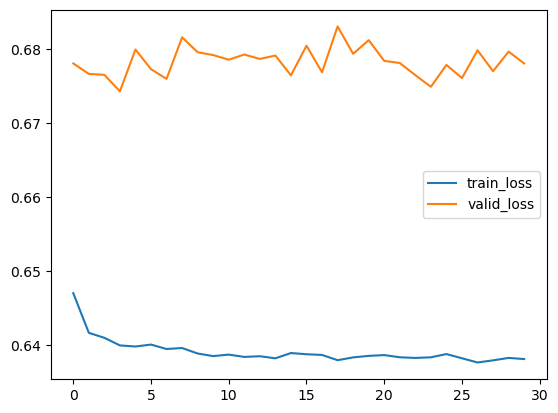

In [272]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)), train_loss_list, label="train_loss")
plt.plot(range(len(valid_loss_list)), valid_loss_list, label="valid_loss")
plt.legend()
plt.show()

## Confusion Matrix

In [1]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

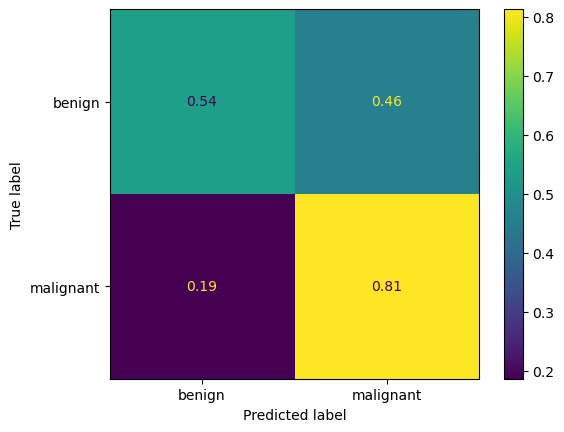

In [19]:
cm = confusion_matrix(y_true_list, y_pred_list, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["benign", "malignant"])
disp.plot()

plt.show()